# Use Topic-Specific PageRank to Perform Collaborative Filtering

First we'll need to import the relevant packages

In [42]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy import sparse
from fast_pagerank import pagerank_power
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm

np.random.seed(0)
tqdm.pandas()

Now let's load in the reviews data and produce our bipartite ratings/reviewers graph

In [2]:
ratings = pd.read_csv('../raw/ratings.csv')

# Let's enumerate the elements so we can use them as indices
users = ratings['userId'].unique()
users = pd.DataFrame(users, columns=['userId'])
users['user_index'] = users.index

# Note we need to add the number of users to the movie index so we don't have overlapping indices
# Since the graph is bipartite but the package doesn't support this, we need to implement it ourselves
movies = pd.read_csv('../raw/movies.csv')
movies['movie_index'] = movies.index + users.shape[0]

# Count the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()
ratings_per_movie = pd.DataFrame(ratings_per_movie, columns=['num_ratings'])
movies = pd.merge(movies, ratings_per_movie, on='movieId')

# Get the TMDB IDs for each movie
links = pd.read_csv('../raw/links.csv')
movies = pd.merge(movies, links, on='movieId')

# Merge the indices back into the ratings dataframe
ratings = pd.merge(ratings, users, on='userId')
ratings = pd.merge(ratings, movies, on='movieId')

MIN_MOVIE_INDEX = np.min(movies['movie_index'])
MAX_INDEX = np.max(movies['movie_index']) + 1

We'll now need to produce the adjacency matrix

In [3]:
# Now we can create the user-movie matrix
# Note we concat user and movie indices since the matrix is symmetric
user_movie = sparse.csr_matrix(
    (
        pd.concat([ratings['rating'], ratings['rating']]), 
        (pd.concat([ratings['user_index'], ratings['movie_index']]), pd.concat([ratings['movie_index'], ratings['user_index']]))
    ), 
    shape = (MAX_INDEX, MAX_INDEX)
)

In order to filter out movies just "being popular," we'll use the Topic-Specific PageRank algorithm to rank the movies. This algorithm is a variant of the PageRank algorithm that allows us to rank the nodes in a graph based on a specific topic. In this case, the topic is the movies that the user has rated. We'll also want to normalize a movie's TSPR by their "normal" PR.

In [4]:
unpersonalized_pr = pagerank_power(user_movie, p=0.85)

Let's compute the TSPR for a specific movie

In [5]:
def compute_tspr(index, adjacency, unpersonalized_pr):
    personalize = np.zeros(MAX_INDEX)
    personalize[index] = 1
    pr = pagerank_power(adjacency, p=0.85, personalize=personalize)
    return pr / unpersonalized_pr

relative_pr = compute_tspr(162541, user_movie, unpersonalized_pr) # Toy Story

Get list of indices with highest pagerank

In [6]:
# Get the top 10 indices
top_indices = np.argsort(relative_pr[MIN_MOVIE_INDEX:])[::-1][:10]
top_df = pd.DataFrame(top_indices + MIN_MOVIE_INDEX, columns=['movie_index'])
top_df = pd.merge(top_df, movies, on='movie_index')

Now that we think this "works," let's get the set of movies that we also have TMDB data for

In [7]:
# Load in the TMDB data
tmdb = pd.read_parquet('../../tmdb/embeddings/movie_descriptions.parquet')
tmdb = tmdb['tmdb_id'].unique()
tmdb = pd.DataFrame(tmdb, columns=['tmdbId'])

# Get the set of TMDB IDs present in both datasets
relevant_movies = pd.merge(movies, tmdb, on='tmdbId', how='inner')

Collaborative filtering generally only works with "many" reviews. Let's filter out movies with relatively few reviews.

In [8]:
# Filter only to popular movies
RATING_THRESHOLD = 10000
popular_movies = relevant_movies[relevant_movies['num_ratings'] > RATING_THRESHOLD]

Now that we have our movies of interest, let's compute their similarity

In [9]:
# For each movie, compute the topic-specific pagerank
indices = popular_movies['movie_index'].values

tspr_generator = (compute_tspr(index, user_movie, unpersonalized_pr) for index in indices)
tsprs = []
for tspr in tqdm(tspr_generator, total=len(indices)):
    tsprs.append(tspr)

100%|██████████| 258/258 [23:46<00:00,  5.53s/it]


Now that we have the TSPR vectors, we can melt them into a long dataframe to match the format of our text similarity data.

In [10]:
# Convert TSPRs to a DataFrame
tspr_df = pd.DataFrame(tsprs, columns=[f'tspr_{i}' for i in range(len(tsprs[0]))])
tspr_df['movie_index_a'] = indices

# Reshape long
tspr_df = tspr_df.melt(id_vars='movie_index_a', var_name='movie_index_b', value_name='tspr')
tspr_df['movie_index_b'] = tspr_df['movie_index_b'].str.replace('tspr_', '').astype(int)

# Drop if movie not in indices
tspr_df = tspr_df[tspr_df['movie_index_b'].isin(indices)]

# Merge the TMDB IDs back on given the indices
tspr_df = pd.merge(tspr_df, movies, left_on='movie_index_a', right_on='movie_index', how='left')
tspr_df = tspr_df.rename(columns={'tmdbId': 'tmdb_id_1'})
tspr_df = pd.merge(tspr_df, movies, left_on='movie_index_b', right_on='movie_index', how='left')
tspr_df = tspr_df.rename(columns={'tmdbId': 'tmdb_id_2'})

Now let's read in the text distances and set them up to be merged with the TSPR data.

In [11]:
# Get the text distance pairings
# Note these were originally only the triangle, so we need to add the other half
text_distances = pd.read_parquet('../../movie_text_distances/output/movie_text_distances.parquet')
text_distances['text_similarity'] = 1 - text_distances['distance']
text_distances_copy = text_distances.copy()
text_distances_copy['temp'] = text_distances_copy['tmdb_id_1']
text_distances_copy['tmdb_id_1'] = text_distances_copy['tmdb_id_2']
text_distances_copy['tmdb_id_2'] = text_distances_copy['temp']
text_distances_copy = text_distances_copy.drop(columns=['temp'])
text_distances = pd.concat([text_distances, text_distances_copy], axis=0)

Merge the two types of distances together

In [82]:
# Merge the two sets of distances
merged_df = pd.merge(tspr_df, text_distances, on=['tmdb_id_1', 'tmdb_id_2'], how='left')

# Drop if num_ratings_x num_ratings_y is too small
# Otherwise collaborative filtering generally doesn't work well
merged_df = merged_df[(merged_df['num_ratings_x'] > 10000) & (merged_df['num_ratings_y'] > 10000)]

# Drop if tmdb_id_1 == tmdb_id_2
merged_df = merged_df[merged_df['tmdb_id_1'] != merged_df['tmdb_id_2']]

# Let's cache the merged dataframe
merged_df.to_parquet('../output/merged_df.parquet')

Now we can plot the two measures against each other:

Track how correlation changes as the threshold increases

In [83]:
thresholds = [1000 * i for i in range(10, 51)]
correlations = []
coefficients = []
errors = []
counts = []
for threshold in thresholds:
    # Sufficiently many reviews per movie
    filtered_df = merged_df[(merged_df['num_ratings_x'] > threshold) & (merged_df['num_ratings_y'] > threshold)]

    # No self-similarities
    filtered_df = filtered_df[filtered_df['tmdb_id_1'] != filtered_df['tmdb_id_2']]

    # No missing values
    filtered_df = filtered_df.dropna()

    # Compute correlation
    correlation = filtered_df['text_similarity'].corr(np.log(filtered_df['tspr']))
    correlations.append(correlation)
    
    # Compute counts
    counts.append(filtered_df.shape[0])

    # Regress log TSPR on text similarity
    X = sm.add_constant(filtered_df['text_similarity'])
    y = np.log(filtered_df['tspr'])
    model = sm.OLS(y, X)
    results = model.fit()
    coefficients.append(results.params['text_similarity'])
    errors.append(results.bse['text_similarity'])



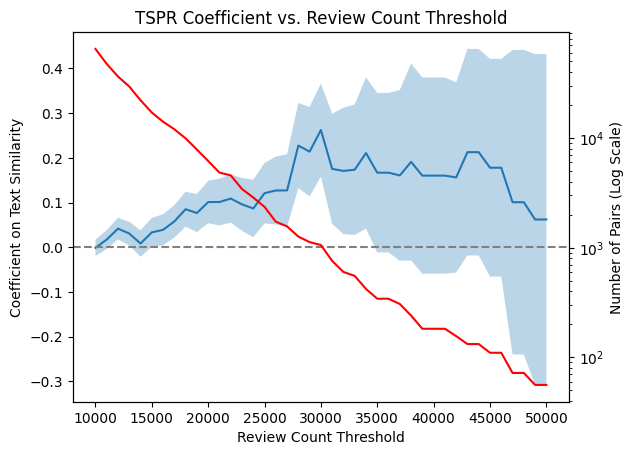

In [89]:
# Plot the correlation vs threshold
plt.plot(thresholds, coefficients)
plt.fill_between(thresholds, np.array(coefficients) - 1.96 * np.array(errors), np.array(coefficients) + 1.96 * np.array(errors), alpha=0.3)
plt.xlabel('Review Count Threshold')
plt.ylabel('Coefficient on Text Similarity')
plt.title('TSPR Coefficient vs. Review Count Threshold')

# Grey dashed horizontal line at 0
plt.axhline(y=0, color='grey', linestyle='--')

# Add the density of the points
plt.twinx()
plt.plot(thresholds, counts, color='red')
plt.ylabel('Number of Pairs (Log Scale)')
plt.yscale('log')

# Save plot to disk
plt.savefig('../output/threshold_vs_coefficient.png')

plt.show()

Based on the plot above, let's examine the correlation for a threshold of 30000

C:\Users\gmoor\AppData\Local\Temp\ipykernel_22492\2872650635.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binscatter_df = truncated_df.groupby('text_sim_bins').agg({


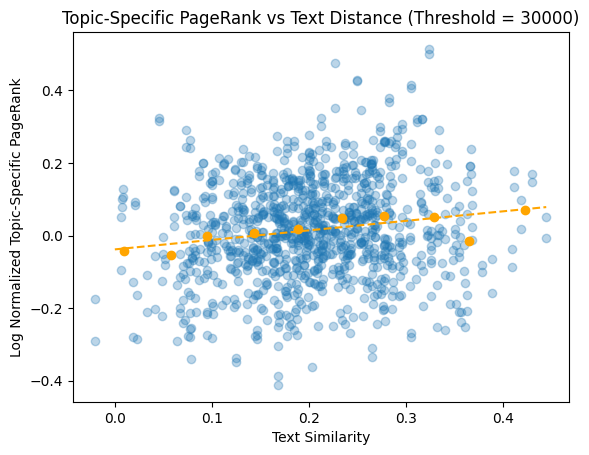

In [86]:
THRESHOLD = 30000

# Create DF using threshold from above
truncated_df = merged_df[(merged_df['num_ratings_x'] > THRESHOLD) & (merged_df['num_ratings_y'] > THRESHOLD)]
truncated_df = truncated_df[truncated_df['tmdb_id_1'] != truncated_df['tmdb_id_2']]
truncated_df = truncated_df.dropna()

# Plot the two distances
plt.scatter(
    truncated_df['text_similarity'], 
    np.log(truncated_df['tspr']), 
    alpha = 0.3
)

# Add a binscatter
truncated_df['text_sim_bins'] = pd.cut(truncated_df['text_similarity'], bins=10)
truncated_df['log_tspr'] = np.log(truncated_df['tspr'])
binscatter_df = truncated_df.groupby('text_sim_bins').agg({
    'text_similarity': 'mean', 
    'tspr': 'mean',
    }).reset_index()

plt.scatter(
    binscatter_df['text_similarity'], 
    np.log(binscatter_df['tspr']),
    color='orange'
)

# Regress log TSPR on text similarity
X = sm.add_constant(truncated_df['text_similarity'])
y = np.log(truncated_df['tspr'])
model = sm.OLS(y, X)
results = model.fit()
coefficient = results.params['text_similarity']
error = results.bse['text_similarity']

# Add the regression line
x = np.linspace(0, max(truncated_df['text_similarity']), 100)
y = coefficient * x + results.params['const']
plt.plot(
    x, 
    y, 
    color='orange',
    # Make the line dashed
    linestyle='dashed'
)

plt.ylabel('Log Normalized Topic-Specific PageRank')
plt.xlabel('Text Similarity')
plt.title(f'Topic-Specific PageRank vs Text Distance (Threshold = {THRESHOLD})')

# Save plot to disk
plt.savefig('../output/tspr_vs_text_30000.png')

plt.show()